# Tutorial Notebook for PSISIM KPIC VFN Mode
This notebook shows how psisim can be used to a simulated observation with the VFN mode of KPIC Phase II. It is a direct analog to the PSISIM HISPEC Tutorial notebook with the only change being that this simulation is run with the VFN mode.

First import all the things and setup the plot things

In [1]:
from psisim import telescope,instrument,observation,spectrum,universe,plots,signal
import time
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
from importlib import reload
import speclite.filters
from scipy.interpolate import interp1d, RegularGridInterpolator as rgi
from scipy.ndimage import gaussian_filter
from scipy.ndimage.filters import median_filter
from scipy.signal import medfilt, correlate
from numpy.random import poisson, randn
import copy 

SMALL_SIZE = 32
MEDIUM_SIZE = 40
BIGGER_SIZE = 48

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

/usr/local/lib/python3.6/dist-packages/pysynphot/locations.py:47: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/usr/local/lib/python3.6/dist-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/usr/local/lib/python3.6/dist-packages/numba/errors.py:137: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


## Initial Setup

Setup the path to the peripheral files and load in the filter objects from speclite

In [2]:
path = '/scr3/dmawet/ETC/'
filters = spectrum.load_filters()

## Telescope Setup

A *telescope* object contains the telecope parameters, the site characteristics and the current conditions. 

In [3]:
keck = telescope.Keck(path=path)
keck.airmass=1.1
keck.water_vapor=1.6
keck.seeing = keck.median_seeing

## Instrument Setup

An _instrument_ object contains both the static instrument parameters, as well as the current observing setup

In [4]:
#Initialize a kpic object and set the current filter
kpic = instrument.kpic_phaseII(telescope=keck)
kpic.set_current_filter("TwoMASS-K")

#Get the set of wavelengths based on the current instrument setup
wavelengths = kpic.get_wavelength_range()

# Set the observing mode: Exposure time (per exposure), # of Exposures, filter name, wavelength array, mode, charge for VFN
kpic.set_observing_mode(2*3600, 1,'TwoMASS-K', wavelengths,mode="vfn",vortex_charge=1) 

## Generate some Spectra

We can now generate a host spectrum. Host properties taken from Dimitri's VFN notebook.

In [5]:
#First set the host properties for a Phoenix model. 
host_properties = {"StarLogg":4.00*u.dex(u.cm/u.s**2),"StarTeff":4400*u.K,"StarZ":'-0.0',"StarAlpha":"0.0",
                    "StarRadialVelocity":-50*u.km/u.s,
                    "StarVsini":10*u.km/u.s,
                    "StarLimbDarkening":0.2}

#Now setup the user parameters that a Phoenix model needs: (path, object_filter, magnitude_in_object_filter,
# filters_object,current_filter). 
host_user_params = (path,'TwoMASS-K',5.0,filters,kpic.current_filter)

#Generate the spectrum! (Here we apply a doppler shift and rotationally broaden)
host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,kpic.current_R,model="Phoenix",
                                              user_params=host_user_params,doppler_shift=True,broaden=True,
                                              delta_wv=kpic.current_dwvs)


/usr/local/lib/python3.6/dist-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


Plot the Spectrum!

Text(0.5, 1.0, 'Host Spectrum')

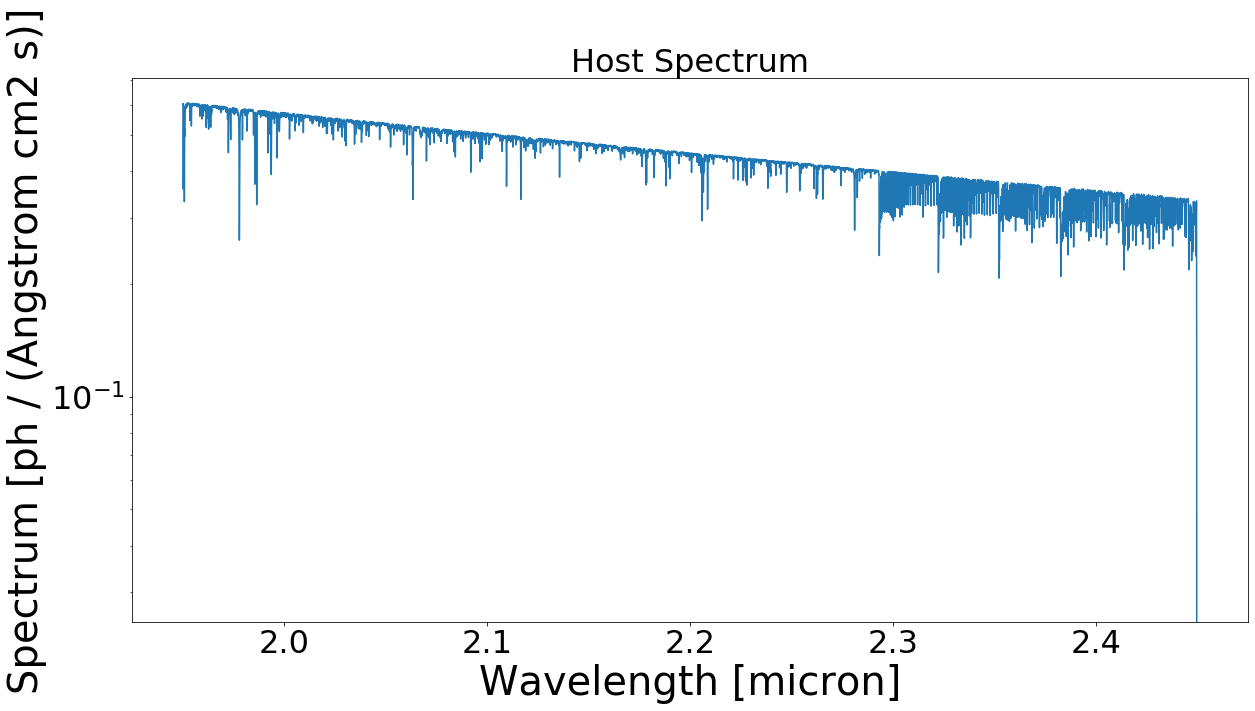

In [6]:
plt.figure(figsize=(20,10))

plt.semilogy(wavelengths,host_spectrum.spectrum)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(host_spectrum.spectrum.unit))
plt.title("Host Spectrum")

Now we can generate a target spectrum as well. Target properties taken from Dimitri's VFN notebook.

In [7]:
obj_properties = {"StarLogg":3.25*u.dex(u.cm/u.s**2),"StarTeff":700*u.K,"StarRadialVelocity":10*u.km/u.s,"StarVsini":8*u.km/u.s,
                  "StarLimbDarkening":0.2}

obj_user_params = (path,'TwoMASS-K',18,filters,kpic.current_filter)

obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,kpic.current_R,model="Sonora",
                                             user_params=obj_user_params,doppler_shift=True,broaden=True,
                                             delta_wv=kpic.current_dwvs)

Text(0.5, 1.0, 'Target Object Spectrum')

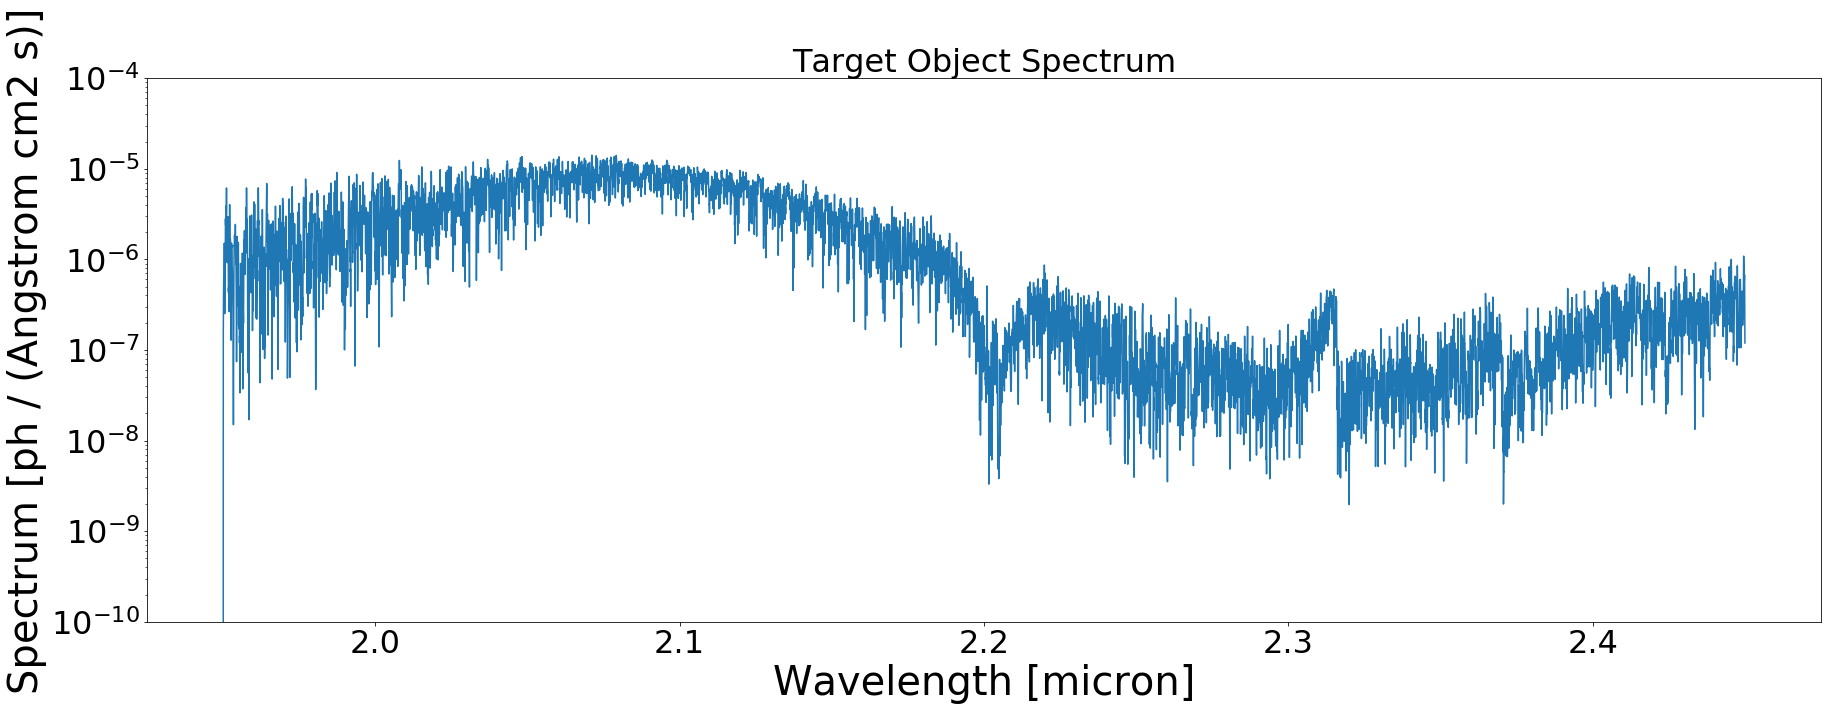

In [8]:
plt.figure(figsize=(30,10))

plt.semilogy(wavelengths,obj_spectrum.spectrum)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spectrum.spectrum.unit))
plt.ylim(1e-10,1e-4)
plt.title("Target Object Spectrum")

### Because of the original PSISIM design considerations, we want the object spectrum in contrast units

In [9]:
obj_spectrum.spectrum /= host_spectrum.spectrum

/home/aidan/.local/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Text(0.5, 1.0, 'Host-Target Contrast Spectrum')

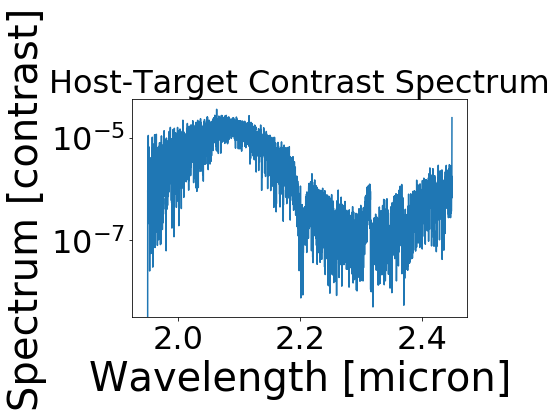

In [10]:
plt.semilogy(wavelengths,obj_spectrum.spectrum)
plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [contrast]")
plt.title("Host-Target Contrast Spectrum")

# Simulate an observation

First set some extra parameters

In [11]:
# The angular separation of the companion, in milliarcsecond
host_properties['AngSep'] = 45*0.9 *u.mas  # 0.9lam/D is the peak planet location for charge 1 and 45mas is 1lam/D at 2um (k-band)

# Convert angular sep to arcseconds for repeated use later in the script
planet_sep = host_properties['AngSep'].to(u.arcsec)

# Set the host star's angular diameter, which defines the nulling geometric leakage
host_diam = 1 *u.mas  
kpic.set_vfn_host_diameter(host_diam)

#Get the host star magnitude in the AO filter
host_properties["StarAOmag"] = spectrum.get_model_ABmags(host_properties,[kpic.ao_filter], model='Phoenix',
                                                         verbose=False,user_params = host_user_params)
kpic.ao_mag = host_properties["StarAOmag"]

#KPIC doesn't care about the spectral type, but we need to include the paramter
host_properties['StarSpT'] = None

## Actually simulate the observation 

In [12]:
obj_spec,total_noise,stellar_spec,thermal_spec,noise_components = observation.simulate_observation(keck,kpic,host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                      post_processing_gain = 10,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False)

/home/aidan/.local/lib/python3.6/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Plot it!

(0.0001, 200.0)

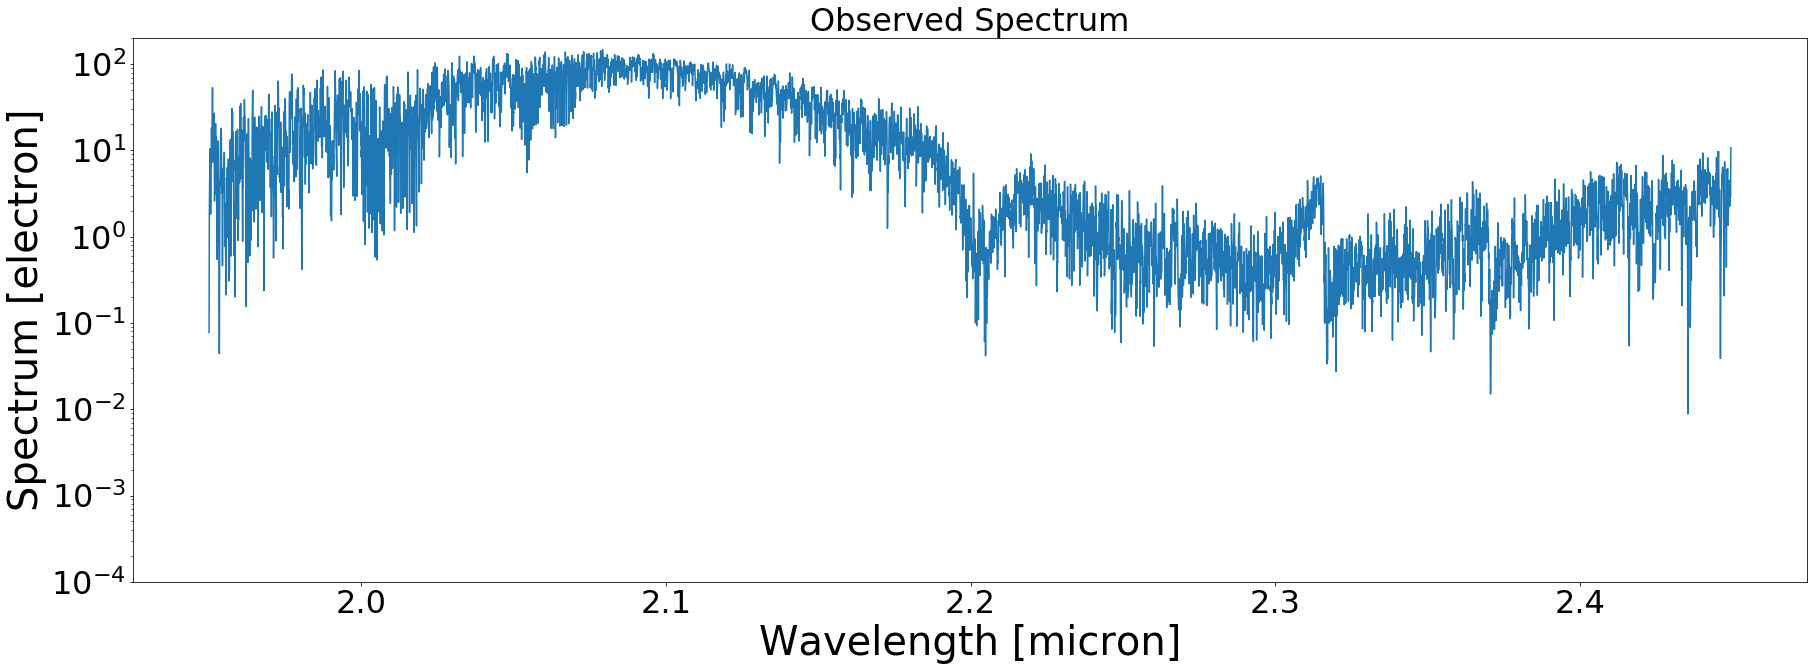

In [13]:
plt.figure(figsize=(30,10))

plt.semilogy(wavelengths,obj_spec)

plt.xlabel("Wavelength [{}]".format(wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(obj_spec.unit))
plt.title("Observed Spectrum")
plt.ylim(1e-4,2e2)

## Now let's cycle through the available filters and collect all the results 

In [14]:
reload(observation)

<module 'psisim.observation' from '/home/aidan/code/psisim/psisim/observation.py'>

In [15]:
all_wavelengths = []
full_host_spectrum = []
full_obj_spectrum = []
full_obj_spectrum_nosky = []
full_total_noise = []
full_thermal_spec = []
full_noise_components = []
full_speckle_noise = []


for kpic_filter in kpic.filters:
    
    #Setup the instrument
    kpic.set_current_filter(kpic_filter)
    wavelengths = kpic.get_wavelength_range()
    kpic.set_observing_mode(2*3600,1,kpic_filter, wavelengths,mode="vfn",vortex_charge=1) 
    
    
    host_user_params = (path,'TwoMASS-K',5.0,filters,kpic.current_filter)
    host_spectrum = spectrum.get_stellar_spectrum(host_properties,wavelengths,kpic.current_R,
                                                  model="Phoenix",user_params=host_user_params,
                                                  doppler_shift=True,broaden=True,delta_wv=kpic.current_dwvs)
    
    obj_user_params = (path,'TwoMASS-K',18,filters,kpic.current_filter)
    obj_spectrum = spectrum.get_stellar_spectrum(obj_properties,wavelengths,kpic.current_R,model="Sonora",
                                                 user_params=obj_user_params,doppler_shift=True,broaden=True,
                                                 delta_wv=kpic.current_dwvs)

    obj_spectrum.spectrum /= host_spectrum.spectrum
    
    obj_spec,total_noise,stellar_spec,thermal_spec,noise_components= observation.simulate_observation(keck,kpic,
                                                                                      host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                      post_processing_gain = np.inf,
                                                                                      return_noise_components=True,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False,
                                                                                      plot=False,
                                                                                      sky_on=True)
    obj_spec_no_sky,_,_,_ = observation.simulate_observation(keck,kpic,
                                                                                      host_properties,
                                                                                      obj_spectrum.spectrum,wavelengths,1e5,
                                                                                      inject_noise=False,verbose=True,
                                                                                      post_processing_gain = np.inf,
                                                                                      return_noise_components=False,
                                                                                      stellar_spec=host_spectrum.spectrum,
                                                                                      apply_lsf=True,
                                                                                      integrate_delta_wv=False,
                                                                                      plot=False,
                                                                                      sky_on=False)

    full_speckle_noise.append(kpic.get_speckle_noise(planet_sep,host_properties['StarAOmag'],kpic.current_filter,wavelengths,host_properties['StarSpT'],keck)[0])
    all_wavelengths.append(wavelengths)
    full_host_spectrum.append(stellar_spec)
    full_obj_spectrum.append(obj_spec)
    full_obj_spectrum_nosky.append(obj_spec_no_sky)
    full_total_noise.append(total_noise)
    full_thermal_spec.append(thermal_spec)
    full_noise_components.append(noise_components)

all_wavelengths = np.hstack(all_wavelengths).value*wavelengths.unit
full_host_spectrum = np.hstack(full_host_spectrum).value*stellar_spec.unit
full_obj_spectrum = np.hstack(full_obj_spectrum).value*obj_spec.unit
full_obj_spectrum_nosky = np.hstack(full_obj_spectrum_nosky).value*obj_spec_no_sky.unit
full_total_noise = np.hstack(full_total_noise).value*total_noise.unit
full_noise_components = np.hstack(full_noise_components)*obj_spec.unit
full_thermal_spec = np.hstack(full_thermal_spec).value*thermal_spec.unit
full_speckle_noise = np.hstack(full_speckle_noise)

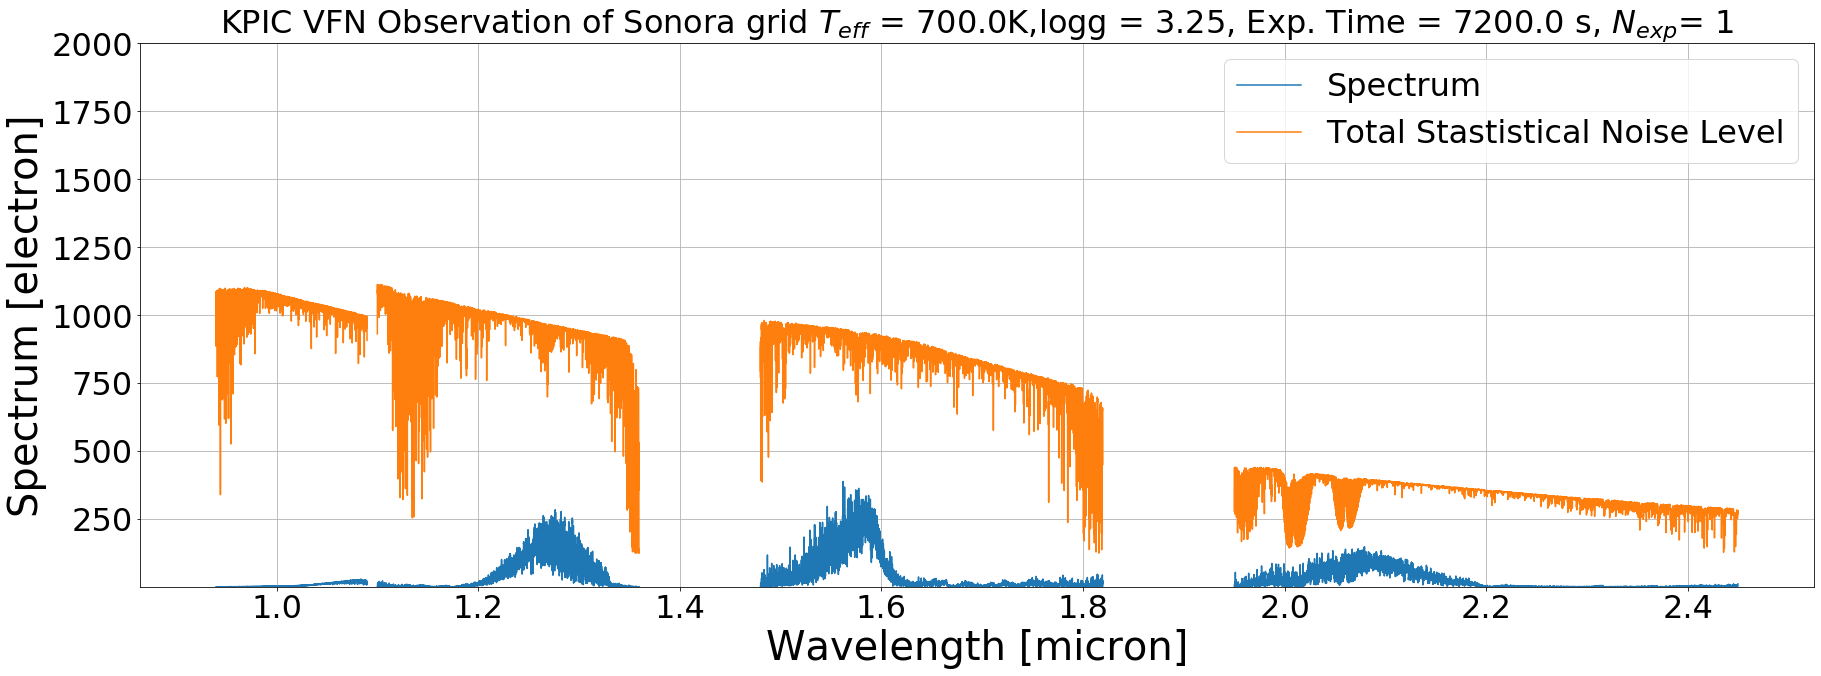

In [16]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_obj_spectrum,label="Spectrum")
plt.plot(all_wavelengths,full_total_noise,label="Total Stastistical Noise Level")

plt.legend()

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(full_obj_spectrum.unit))
plt.title(r"KPIC VFN Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,kpic.exposure_time,kpic.n_exposures))
plt.ylim(1e-4,2e3)
plt.grid()

## We can calculate the signal to noise now


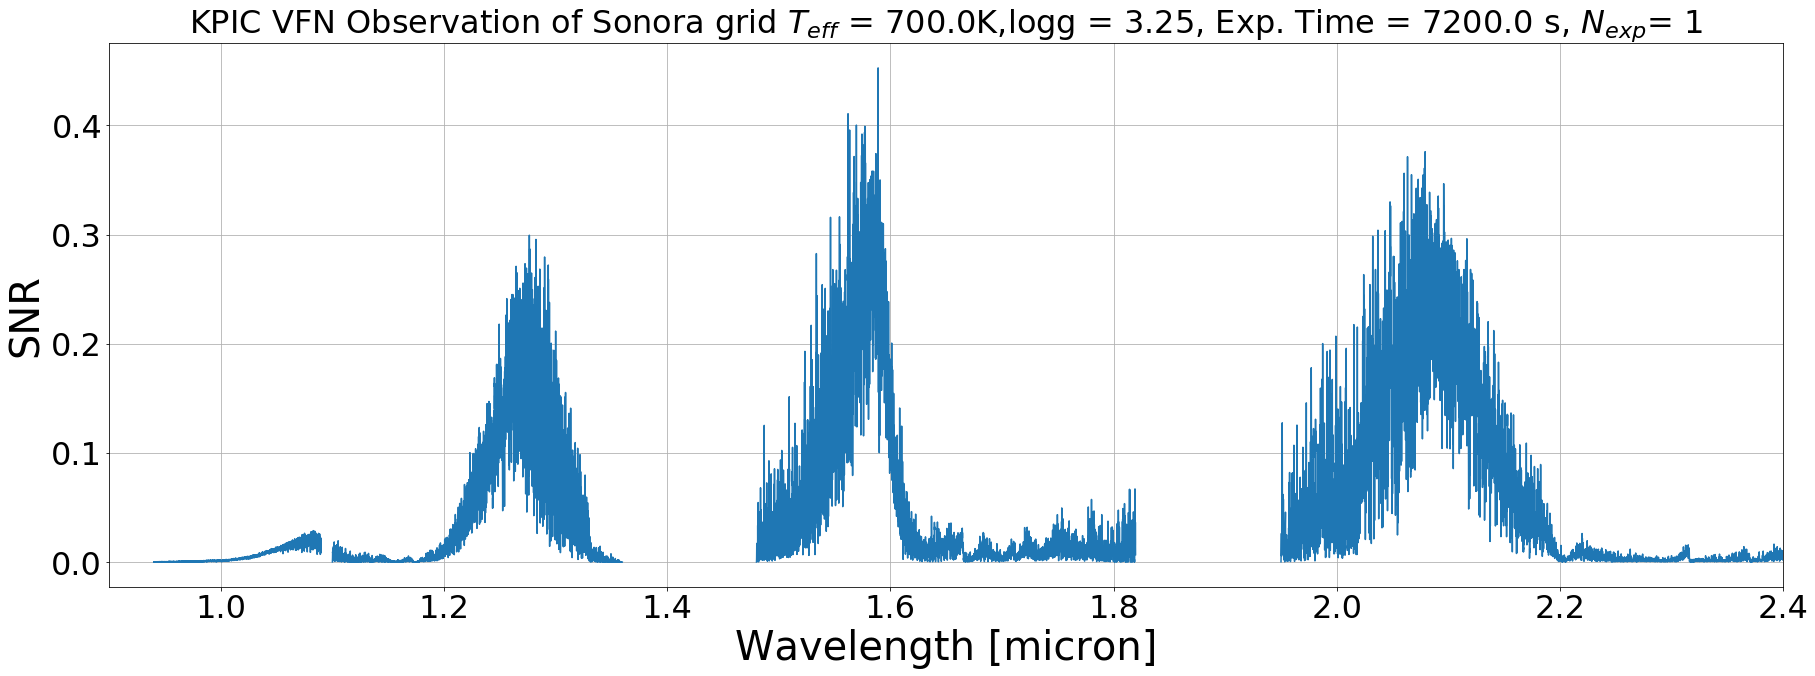

In [17]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_obj_spectrum/full_total_noise)

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("SNR")

plt.title(r"KPIC VFN Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,kpic.exposure_time,kpic.n_exposures))

# plt.ylim(-0.01,0.4)
plt.xlim(0.9,2.4)
plt.grid()
#plt.ylim(-0.1,2.)

### But let's not forget about systematics. We will estimate our ability to remove the host star spectrum and the telluric lines at the .1% level. 

In [18]:
cal = 0.001 #Telluric calibration accuracy of .1%

#The photon flux at the object will be the stellar flux multipled by the contrast there: 
# full_host_spectrum
host_flux_at_obj = full_host_spectrum*kpic.get_speckle_noise(planet_sep,host_properties['StarAOmag'],"",all_wavelengths,None,keck)[0]

systematics = (cal*(host_flux_at_obj+full_thermal_spec))**2 #Variance of systematics

noise_plus_systematics = np.sqrt(full_total_noise**2+systematics)

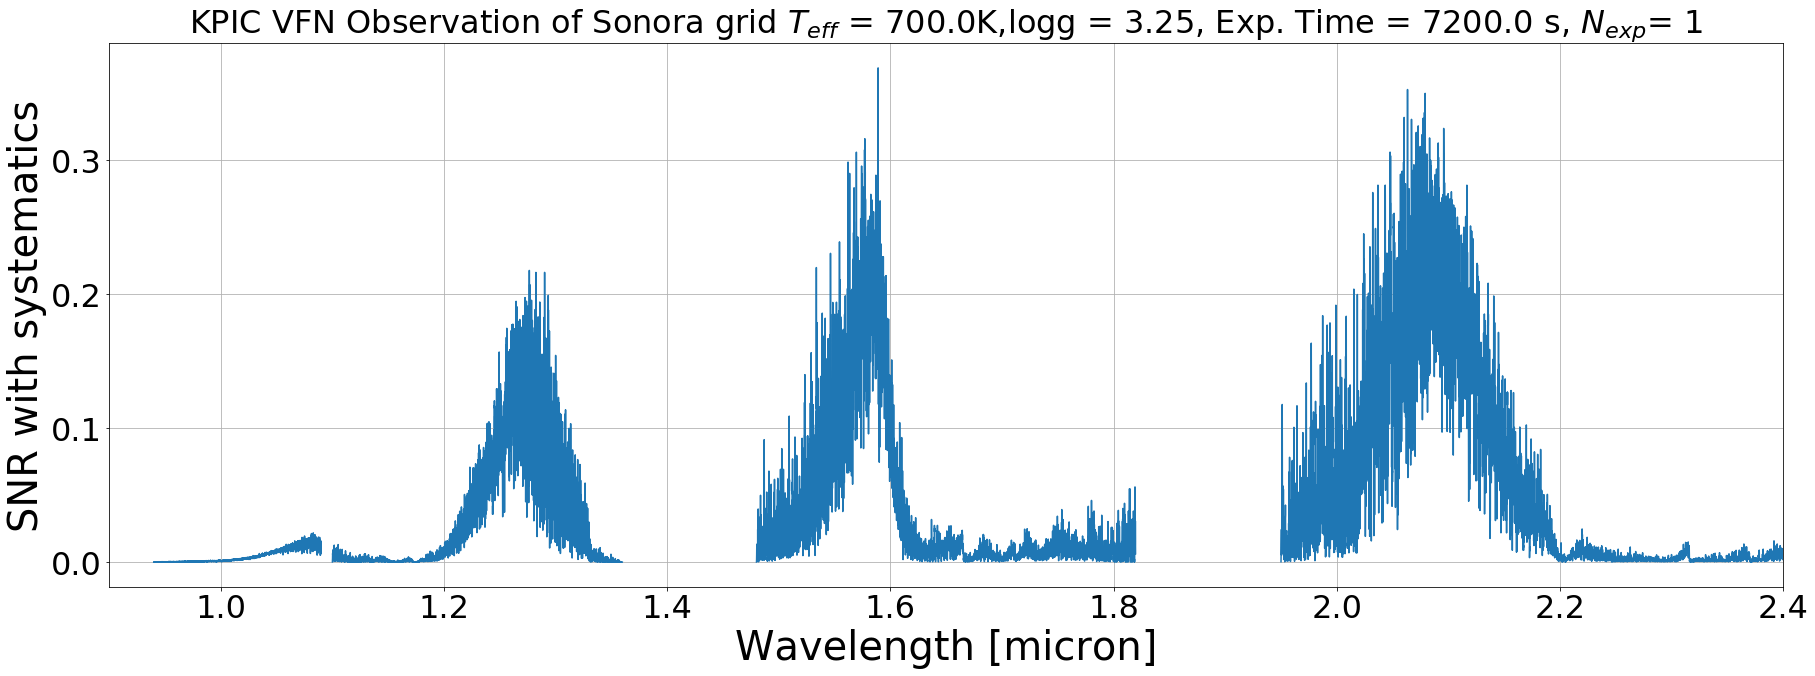

In [19]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_obj_spectrum/noise_plus_systematics)

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("SNR with systematics")

plt.title(r"KPIC VFN Observation of Sonora grid $T_{{eff}}$ = {}K,logg = {}, Exp. Time = {}, $N_{{exp}}$= {}".format(
obj_properties["StarTeff"].value,obj_properties["StarLogg"].value,kpic.exposure_time,kpic.n_exposures))

# plt.ylim(-0.01,0.4)
plt.xlim(0.9,2.4)
plt.grid()
#plt.ylim(-0.1,1.)

## Calculate the CCF-SNR

### We'll do this with in the K-band (the last one from when we cycled through the filters above)

Since we're doing this in k-band we'll want to recalculate the noise with the systematics just for this band

In [20]:
cal = 0.001 #Telluric calibration accuracy of .1%

#The photon flux at the object will be the stellar flux multipled by the contrast there: 
# full_host_spectrum
host_flux_at_obj = stellar_spec*kpic.get_speckle_noise(planet_sep,host_properties['StarAOmag'],"",wavelengths,None,keck)[0]

systematics = (cal*(host_flux_at_obj+thermal_spec))**2 #Variance of systematics

noise_plus_systematics = np.sqrt(total_noise**2+systematics)


Text(0.5, 0, 'Wavelength [micron]')

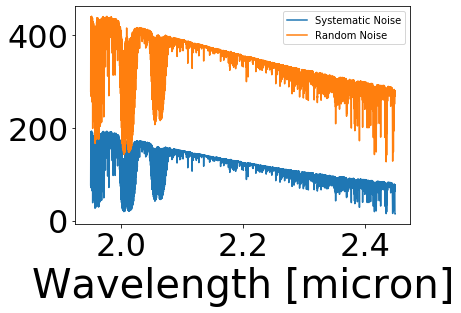

In [21]:
plt.plot(wavelengths,np.sqrt(systematics),label="Systematic Noise")
plt.plot(wavelengths,total_noise,label="Random Noise")
plt.legend(fontsize=10)
plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))

Calculate the sky transmission lines convolved with the line spread function

In [22]:
#Get the wavelength spacing
dwvs = np.abs(wavelengths - np.roll(wavelengths, 1))
dwvs[0] = dwvs[1]
dwv_mean = np.mean(dwvs)
lsf_fwhm = (kpic.lsf_width/dwv_mean).decompose() #Get the lsf_fwhm in units of current wavelength spacing
lsf_sigma = lsf_fwhm/(2*np.sqrt(2*np.log(2))) #Convert to sigma

#Calculate the 
sky_transmission_lsf = gaussian_filter(keck.get_atmospheric_transmission(wavelengths),
                                                                           lsf_sigma.value)

Now get the ccf snr

In [23]:
ccf_snr = signal.compute_ccf_snr_matchedfilter(obj_spec, obj_spec_no_sky, noise_plus_systematics, 
                                            sky_transmission_lsf,
                                               systematics_residuals = cal, 
                                               norm_cutoff=0.8)
print(ccf_snr)

4.131403769379125 1 / electron


We can also calculate the ccf SNR for all the bands

# Some other things we can look at to compare with Dimitri's original notebook "HISPEC MODHIS ETC HDC v3"

#### The thermal spectrum of the sky, telecsope and instrument.

(0.9, 2.4)

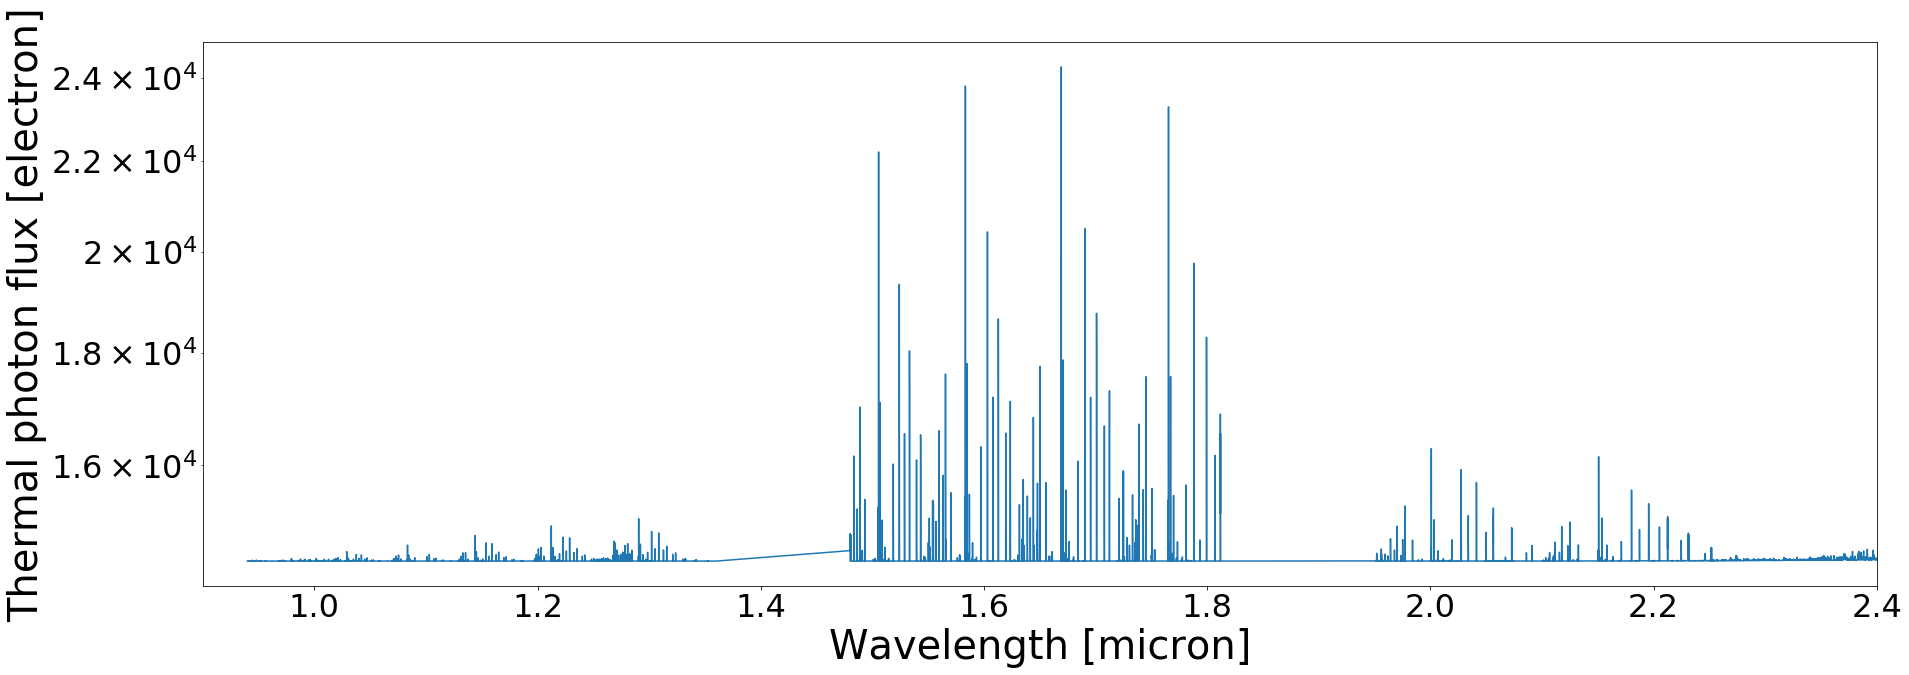

In [24]:
plt.figure(figsize=(30,10))

# plt.semilogy(all_wavelengths,full_host_spectrum)
plt.semilogy(all_wavelengths,full_thermal_spec)

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel('Thermal photon flux [{}]'.format(str((full_thermal_spec).unit)))
# plt.ylim(1e,1e7)
# plt.ylim(1e4,1e8)
plt.xlim(0.9,2.4)


### What about the relative contributions of the different noise components

/usr/local/lib/python3.6/dist-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


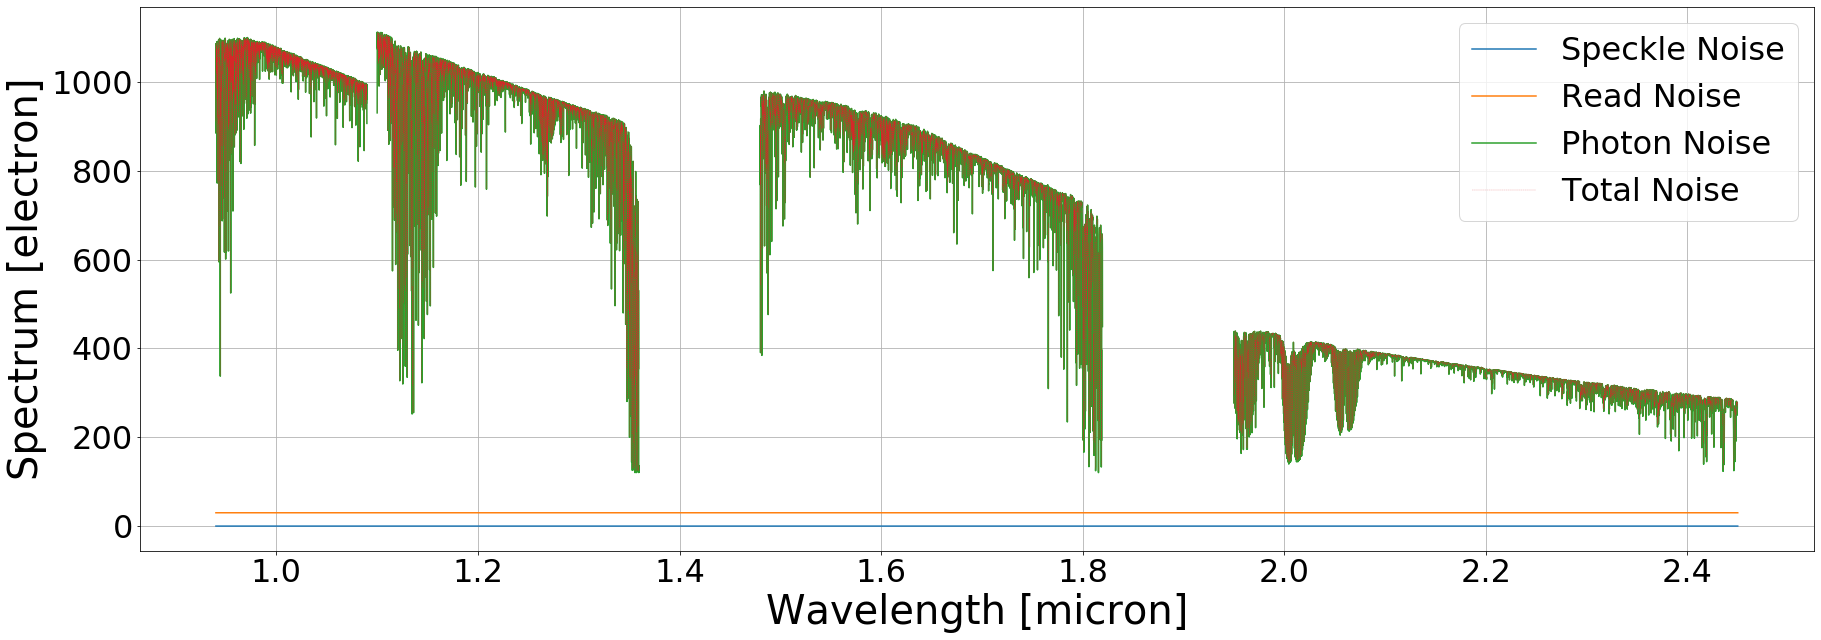

In [25]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,full_noise_components[0],label="Speckle Noise")
plt.plot(all_wavelengths,full_noise_components[1],label="Read Noise")
# plt.plot(all_wavelengths,full_noise_components[2],label="Dark Current Noise")
plt.plot(all_wavelengths,full_noise_components[2],label="Photon Noise")

plt.plot(all_wavelengths,full_total_noise,linestyle="-.",label="Total Noise",linewidth=0.2)

plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Spectrum [{}]".format(full_obj_spectrum.unit))
# plt.ylim(1e0,5e1)
plt.grid()
plt.legend()

## We can also check the throughput of the system: 

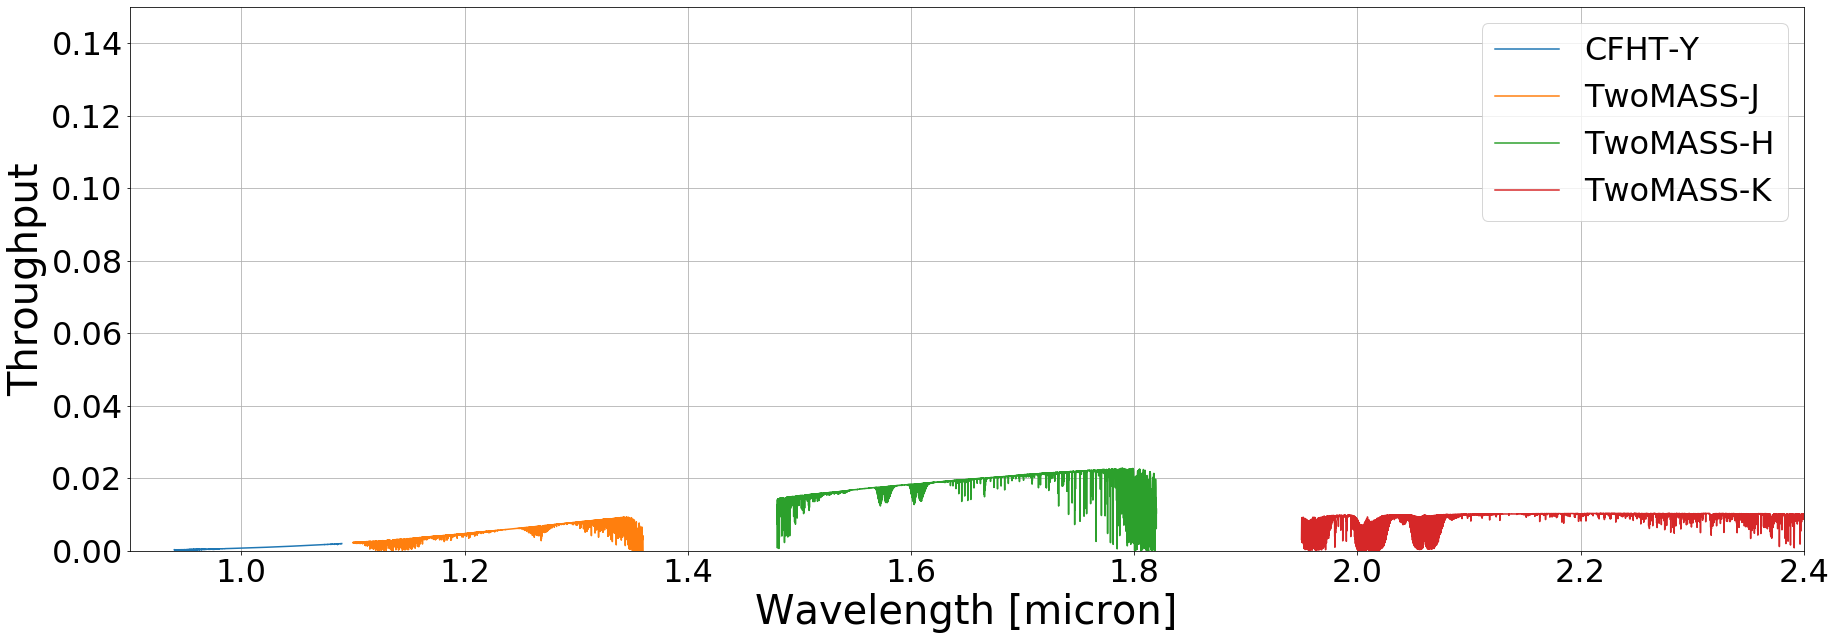

In [26]:
th_sky = []
th_total = []
SR = []

fig = plt.figure(figsize=(30,10))

for kpic_filter in kpic.filters:    
    #Setup the instrument
    kpic.set_current_filter(kpic_filter)
    wavelengths = kpic.get_wavelength_range()
    kpic.set_observing_mode(2*3600,1,kpic_filter, wavelengths,mode='vfn',vortex_charge=1) 
    
    th_sky_tmp = keck.get_atmospheric_transmission(wavelengths)
    th_sky.append(th_sky_tmp)
    # Set planet_flag=True to include VFN planet injection efficiency
    th_total_tmp = keck.get_telescope_throughput(wavelengths,kpic)*kpic.get_inst_throughput(wavelengths,planet_flag=True,planet_sep=planet_sep)*kpic.get_filter_transmission(wavelengths,kpic.current_filter)
    th_total.append(th_total_tmp)
    SR.append(kpic.compute_SR(wavelengths))            
    
    #Dan TODO: not sure what this next line is supposed to plot. What's the 0.95 coeff for? Why recalculate everything
    #plt.plot(wavelengths,0.95*keck.get_atmospheric_transmission(wavelengths)*keck.get_telescope_throughput(wavelengths,kpic)*kpic.get_inst_throughput(wavelengths)*kpic.get_filter_transmission(wavelengths,kpic.current_filter),label=kpic_filter)
    
    plt.plot(wavelengths, th_sky_tmp*th_total_tmp, label=kpic_filter)
    
#     print(np.mean(hispec.current_dwvs))

th_sky = np.hstack(th_sky)
th_total = np.hstack(th_total)
SR = np.hstack(SR)

plt.xlim(0.9,2.4)
plt.ylim(0,0.15)
plt.grid()
plt.xlabel("Wavelength [micron]")
plt.ylabel("Throughput")

plt.legend()

## And the Strehl Ratio

(0.9, 2.4)

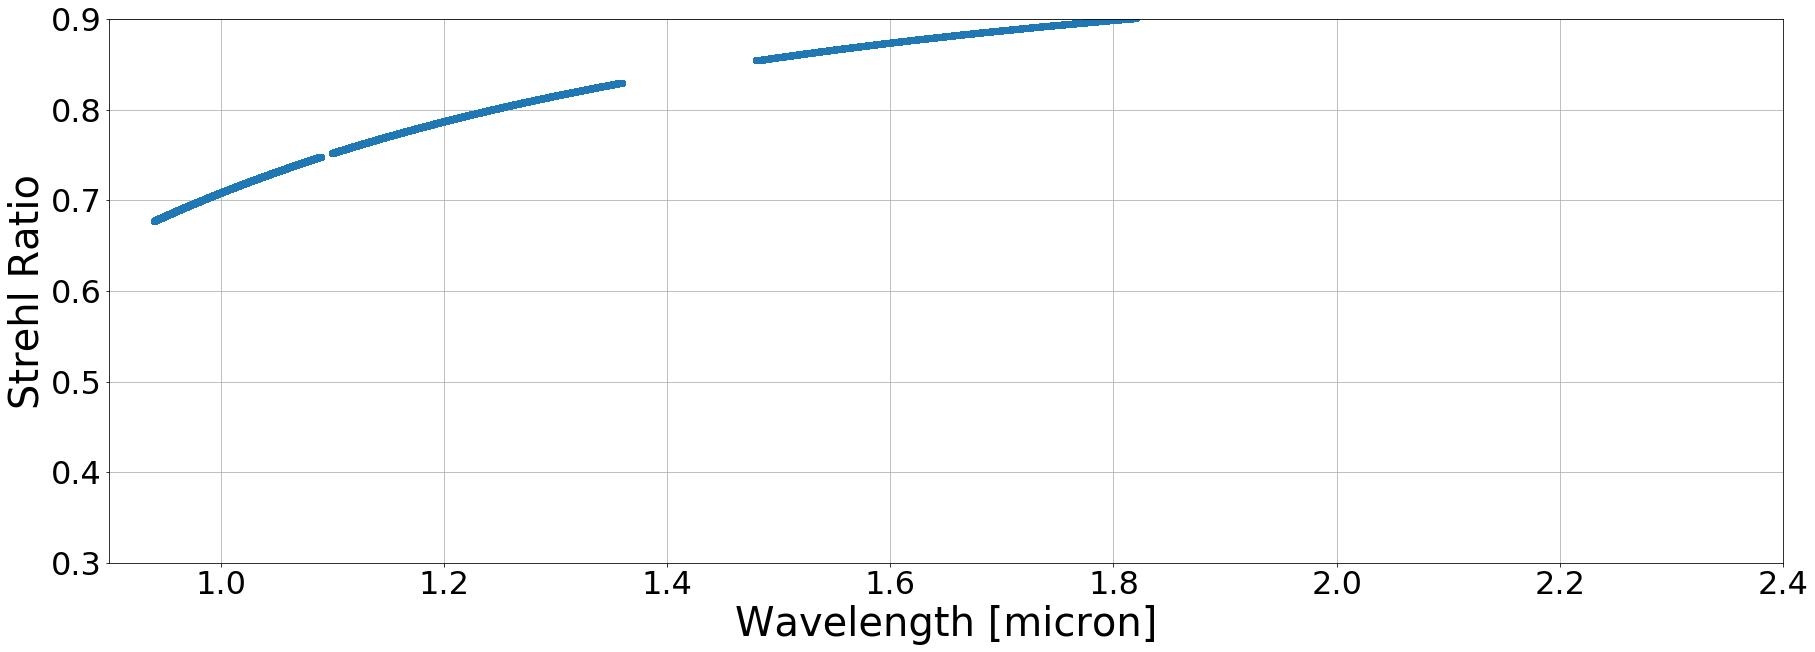

In [27]:
plt.figure(figsize=(30,10))

plt.plot(all_wavelengths,SR,'o')

# plt.ylim(1e-2,0.2)
plt.xlabel("Wavelength [{}]".format(all_wavelengths.unit))
plt.ylabel("Strehl Ratio")
# plt.ylim(1e-4,1e2)
plt.grid()
plt.ylim(0.3,0.9)
plt.xlim(0.9,2.4)

## Check the contrasts and mark the 0.4 arcsecond location for each wavelength

Note: the VFN contrast is independent of the target's position; it depends only on the WFE and Tip/Tilt residuals in the observation.

(7.5, 20)

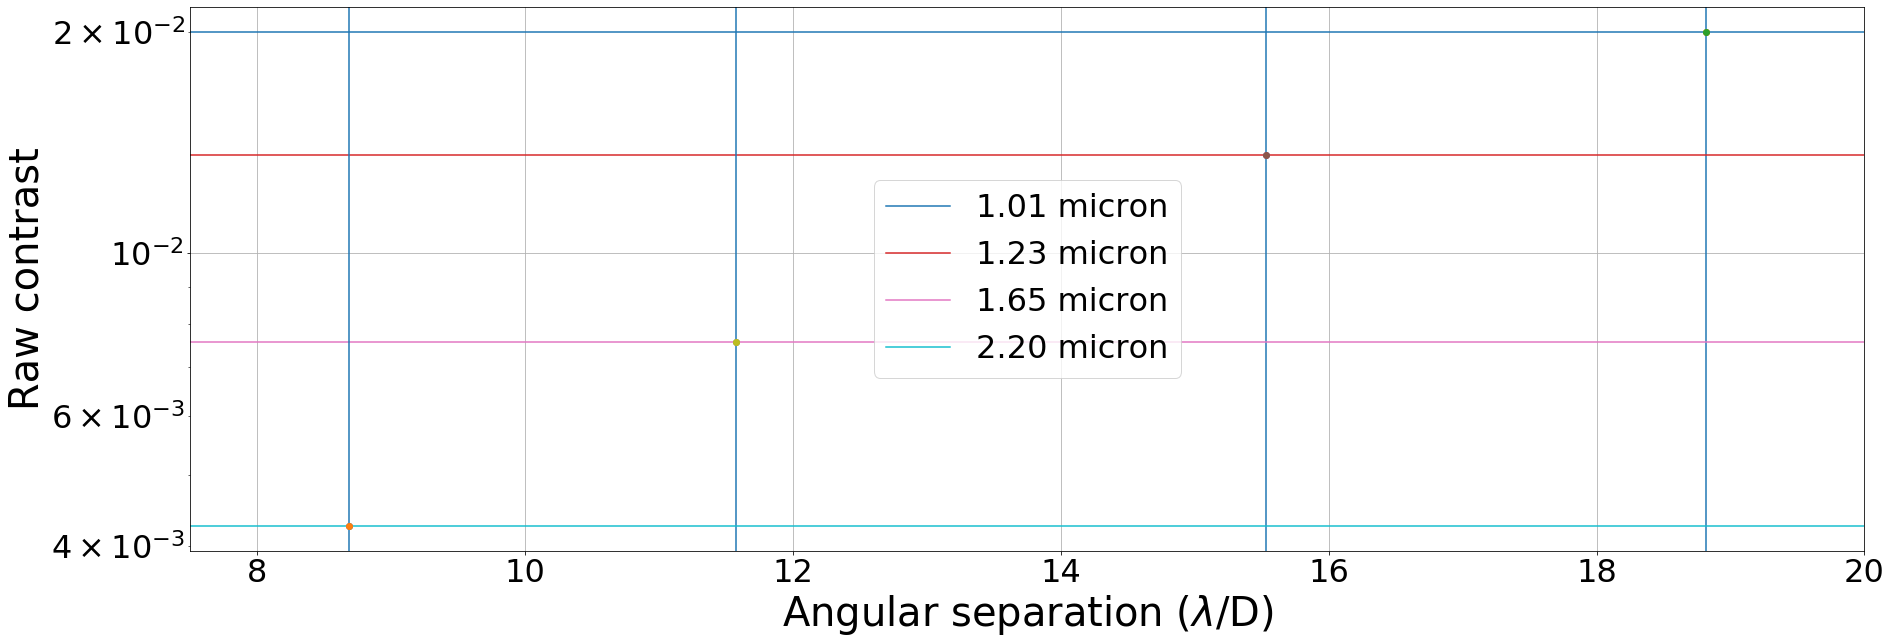

In [28]:
separations = np.arange(0,1.,0.001)*u.arcsecond

plt.figure(figsize=(30,10))

for kpic_filter in kpic.filters:
    
    kpic.set_current_filter(kpic_filter)
    wavelengths = kpic.get_wavelength_range()
    kpic.set_observing_mode(2*3600,1,kpic_filter, wavelengths,mode='vfn',vortex_charge=1) 
    
#     print(wavelengths[int(wavelengths.shape[0]/2):int(wavelengths.shape[0]/2)+2])
    
    contrasts = kpic.get_speckle_noise(separations,host_properties["StarAOmag"],kpic.current_filter,
                                       wavelengths[int(wavelengths.shape[0]/2):int(wavelengths.shape[0]/2)+2],
                                         host_properties['StarSpT'],keck)[:,0]
    
    tsts = kpic.get_speckle_noise(np.array([0.4,0.5,0.6])*u.arcsecond,host_properties["StarAOmag"],
                                       kpic.current_filter,
                                       wavelengths[int(wavelengths.shape[0]/2):int(wavelengths.shape[0]/2)+2],
                                       host_properties['StarSpT'],keck)[0]
    
    plt.semilogy(separations/206265*keck.diameter/np.mean(wavelengths).to(u.m),contrasts,
                 label="{:.2f}".format(np.mean(wavelengths)))
    plt.axvline(0.4/206265*keck.diameter/np.mean(wavelengths).to(u.m))
    plt.plot([0.4/206265*keck.diameter/np.mean(wavelengths).to(u.m)],[tsts],'o')
    
# plt.xlim([0.01,100])
# plt.ylim([1e-7,1])
plt.xlabel('Angular separation ($\lambda$/D)')
plt.ylabel('Raw contrast')
plt.legend()

plt.grid(True)
plt.xlim(7.5,20)
#plt.ylim(1e-5,1e-3)